# Network Analysis of World Trade

### Import necessary libraries

In [1]:
import networkx as nx
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
from mpl_toolkits.basemap import Basemap as Basemap

### Import data as pandas dataframe

We use the [BACI-CEPII dataset](http://www.cepii.fr/CEPII/en/bdd_modele/bdd_modele_item.asp?id=37) that contains data on bilateral trade relations of 200 countries at the product level.

To limit the scope of our complexity, we use only small subsets of this dataset. The data for trade flows of three product categories is analyzed:
1.  Natural Gas
2.  Coffee
3.  Diamonds


In [2]:
natural_gas = pd.read_csv('data/natural_gas.csv')
coffee = pd.read_csv('data/coffee.csv')
diamonds = pd.read_csv('data/diamonds.csv')

# latitude longitudes information of countries
country_locations = pd.read_csv('data/locations.csv')

### Converting the dataframes into NetworkX graph objects

In [3]:
edges_natural_gas = pd.DataFrame(
    {
        "source": list(natural_gas['exporter']),
        "target": list(natural_gas['importer']),
        "value": list(natural_gas['value']),
        "quantity": list(natural_gas['quantity'])
    }
)

edges_diamonds = pd.DataFrame(
    {
        "source": list(diamonds['exporter']),
        "target": list(diamonds['importer']),
        "value": list(diamonds['value']),
        "quantity": list(diamonds['quantity'])
    }
)

edges_coffee = pd.DataFrame(
    {
        "source": list(coffee['exporter']),
        "target": list(coffee['importer']),
        "value": list(coffee['value']),
        "quantity": list(coffee['quantity'])
    }
)

In [4]:
G_natural_gas = nx.from_pandas_edgelist(edges_natural_gas, edge_attr=True, create_using=nx.DiGraph())
G_coffee = nx.from_pandas_edgelist(edges_coffee, edge_attr=True, create_using=nx.DiGraph())
G_diamonds = nx.from_pandas_edgelist(edges_diamonds, edge_attr=True, create_using=nx.DiGraph())

### Power Law Distribution

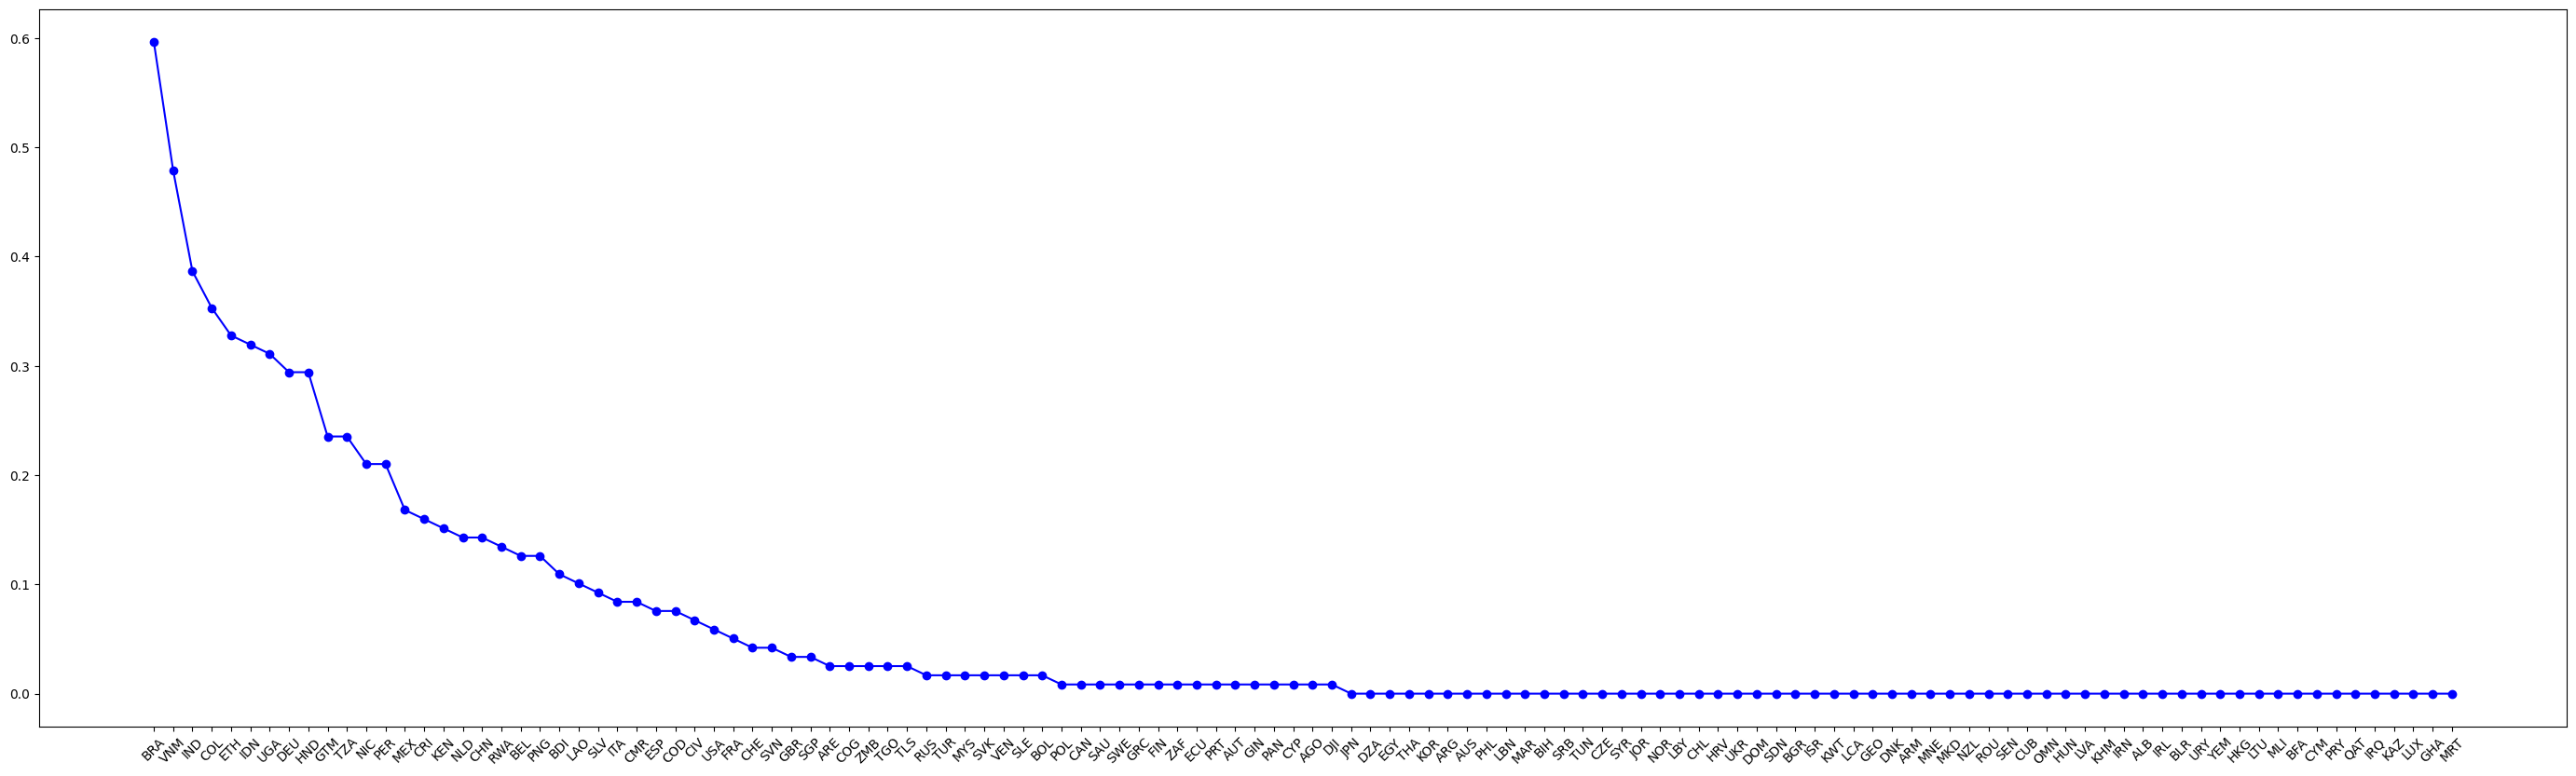

In [5]:
outdeg_dict = nx.out_degree_centrality(G_coffee)
outdeg_dict = dict(sorted(outdeg_dict.items(), key=lambda item: item[1], reverse=True))
plt.figure(figsize=(35, 10))
plt.xticks(rotation=45)
plt.plot(outdeg_dict.keys(), outdeg_dict.values(), marker='o', linestyle='-', color='b')
plt.show()

## Visualizing World Trade - Geographic View v/s Topological View

In [6]:
# function for visualization of trade network
# parameter "geo" determines whether it will be a geographic or topological view
# default value of "geo" is False i.e. default view is topological

def draw_pretty(G, geo=False):
    indeg_dict = nx.in_degree_centrality(G)
    outdeg_dict = nx.out_degree_centrality(G)
    low, *_, high = sorted(indeg_dict.values())
    norm = mpl.colors.Normalize(vmin=low, vmax=high, clip=True)
    mapper = mpl.cm.ScalarMappable(norm=norm, cmap=mpl.cm.coolwarm)
    nsize = [x*20000 for x in outdeg_dict.values()]
    plt.figure(figsize=(40,20))
    lat_long = dict([(i,[a,b]) for i, a,b in zip(country_locations.country, country_locations.long, country_locations.lat)])
    if(geo):
        postemp=lat_long
        latitudes = [lat_long[country][1] for country in lat_long]
        longitudes = [lat_long[country][0] for country in lat_long]
        m = Basemap(projection='merc',llcrnrlon=-180,llcrnrlat=-80,urcrnrlon=180, urcrnrlat=80, lat_ts=0, resolution='l',suppress_ticks=True)
        m.drawcountries(linewidth = 1.5)
        m.drawstates(linewidth = 0.1)
        m.drawcoastlines(linewidth=1.5)
        longitudes, latitudes = m(longitudes, latitudes)
        pos = {}
        for count, (key, value) in enumerate(postemp.items()):
            if(key in G.nodes):
                pos[key] = (longitudes[count], latitudes[count])
    else:
        pos=nx.spring_layout(G, seed=1231)
    nx.draw(G, pos, with_labels=True, node_size=nsize, node_color=[mapper.to_rgba(i) for i in indeg_dict.values()], alpha = 0.8)
    plt.show()

### Geographic View

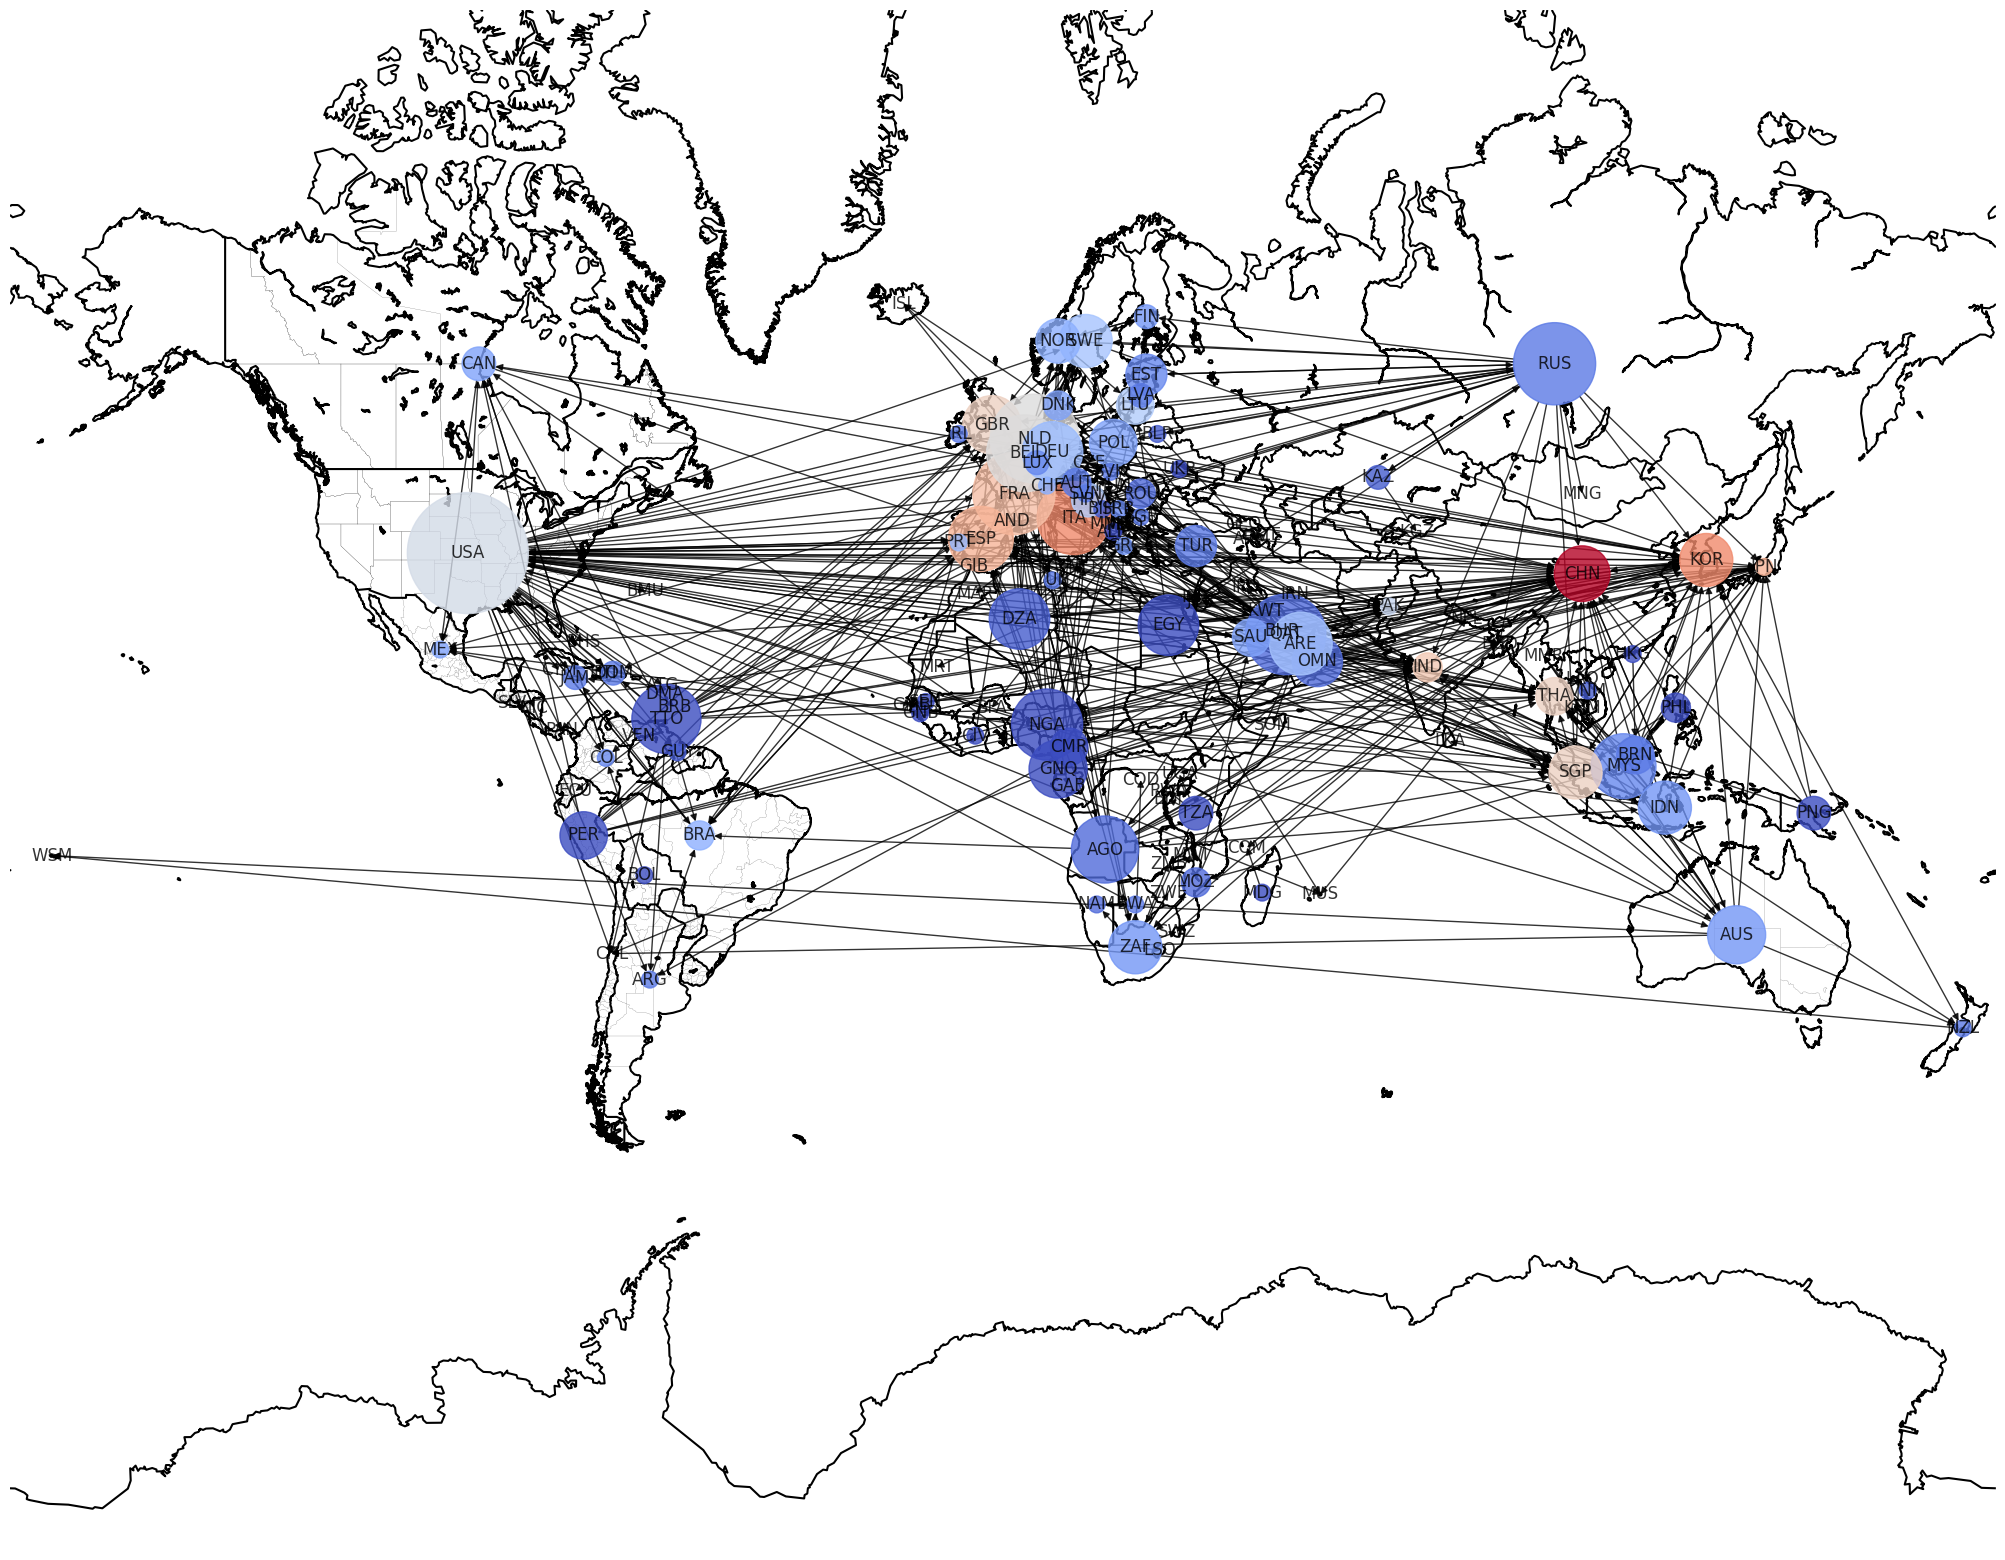

In [7]:
draw_pretty(G_natural_gas, geo=True)

<b>While geographic visualization of international trade provides valuable insights into spatial patterns and regional concentrations of economic activities, it has its limitations when it comes to analyzing the interdependencies among countries.</b>

### Topological View

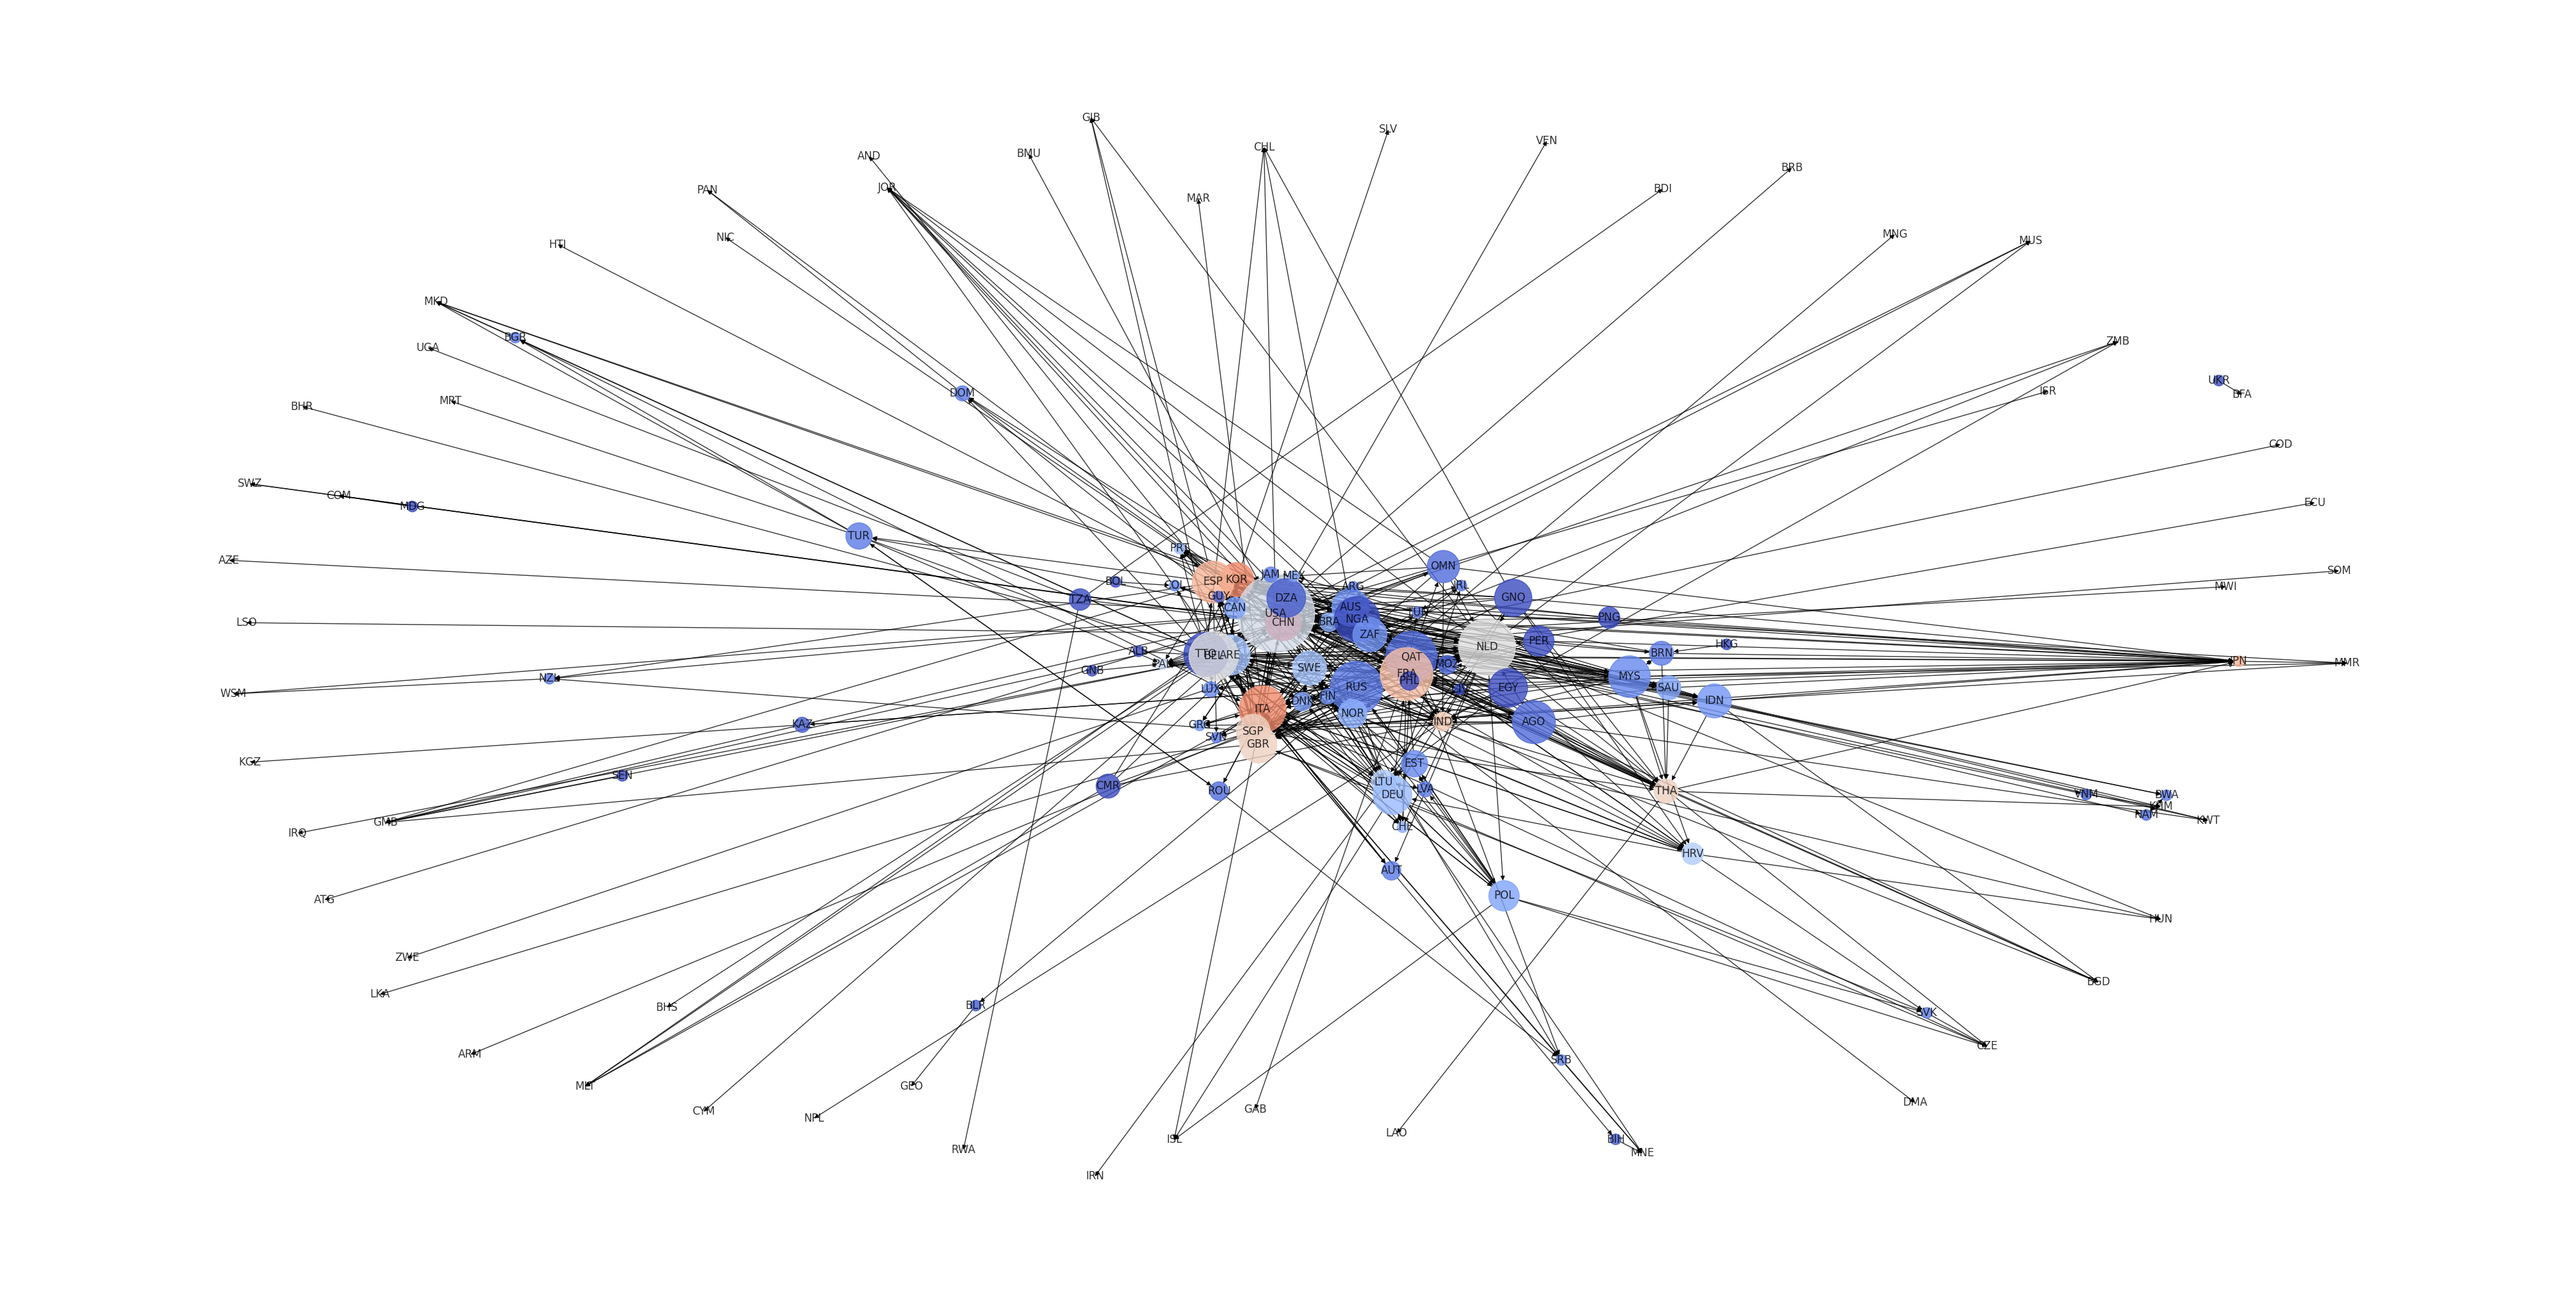

In [8]:
draw_pretty(G_natural_gas, geo=False)

## Centrality Measures

1. Degree
    - Indegree
    - Outedegree
2. Closeness
3. Betweenness

In [9]:
total_outgoing_weight = {node: sum(data['value']/1000000 for _, _, data in G_coffee.out_edges(node, data=True)) for node in G_coffee}

closeness = nx.closeness_centrality(G_coffee)
betweenness = nx.betweenness_centrality(G_coffee)
indegree = nx.in_degree_centrality(G_coffee)
outdegree = nx.out_degree_centrality(G_coffee)

In [10]:
# combining both dicts into one dataframe
df1 = pd.DataFrame(indegree.items(), columns=['country', 'indegree'])
df2 = pd.DataFrame(outdegree.items(), columns=['country', 'outdegree'])
df3 = pd.DataFrame(closeness.items(), columns=['country', 'closeness'])
df4 = pd.DataFrame(betweenness.items(), columns=['country', 'betweenness'])
df5 = pd.DataFrame(total_outgoing_weight.items(), columns=['country', 'export_value'])
merged_df = pd.merge(df1, df2, on='country', how='inner')
merged_df = pd.merge(merged_df, df3, on='country', how='inner')
merged_df = pd.merge(merged_df, df4, on='country', how='inner')
merged_df = pd.merge(merged_df, df5, on='country', how='inner')

merged_df.sort_values(by=['export_value'], inplace=True, ascending=False)

def highlight_rows(x):
    if x.country == 'BRA':
        return ['background-color: lightgreen']*6
    if x.country == 'COL' or x.country == 'VNM' or x.country == 'ETH':
        return ['background-color: yellow']*6
    if x.country == 'DEU' or x.country == 'USA' or x.country == 'ITA':
        return ['background-color: orange']*6
    if x.country == 'MRT' or x.country == 'TCD' or x.country == 'LUX':
        return ['background-color: pink']*6

with pd.option_context('display.max_rows', None, 'display.max_columns', None,):
    display(merged_df.style.apply(highlight_rows, axis=1))

## Community Detection

Modularity = Measure of quality of community divisions within a network

In [11]:
# function to create node colour list
def create_community_node_colors(graph, communities):
    number_of_colors = len(communities[0])
    colors = ["#D4FCB1", "#CDC5FC", "#FFC2C4", "#F2D140", "#F57160", "#2894F5", "#577D32"][:number_of_colors]
    node_colors = []
    for node in graph:
        current_community_index = 0
        for community in communities:
            if node in community:
                node_colors.append(colors[current_community_index])
                break
            current_community_index += 1
    return node_colors


# function to plot graph with node colouring based on communities
def visualize_communities(graph, communities):
    node_colors = create_community_node_colors(graph, communities)
    # Calculate the total incoming weight for each node
    total_incoming_weight = {node: sum(data['value'] for _, _, data in graph.out_edges(node, data=True)) for node in graph}
    # Get the maximum and minimum incoming weight values
    max_weight = max(total_incoming_weight.values())
    min_weight = min(total_incoming_weight.values())
    # Normalize the incoming weights to the desired node size range
    normalized_weights = {node: 10 + ((total_incoming_weight[node] - min_weight) / (max_weight - min_weight)) * 90 for node in graph}
    lat_long = dict([(i,[a,b]) for i, a,b in zip(country_locations.country, country_locations.long, country_locations.lat)])
    postemp=lat_long
    latitudes = [lat_long[country][1] for country in lat_long]
    longitudes = [lat_long[country][0] for country in lat_long]
    m = Basemap(projection='merc',llcrnrlon=-180,llcrnrlat=-80,urcrnrlon=180, urcrnrlat=80, lat_ts=0, resolution='l',suppress_ticks=True)
    m.drawcountries(linewidth = 1)
    m.drawstates(linewidth = 0.1)
    m.drawcoastlines(linewidth=1)
    longitudes, latitudes = m(longitudes, latitudes)
    pos = {}
    for count, (key, value) in enumerate(postemp.items()):
        if(key in graph.nodes):
            pos[key] = (longitudes[count], latitudes[count])
    nx.draw(graph, pos=pos, node_size=[100*normalized_weights[node] for node in graph], node_color=node_colors, with_labels=True, font_size=15, font_color="black", alpha=0.9)

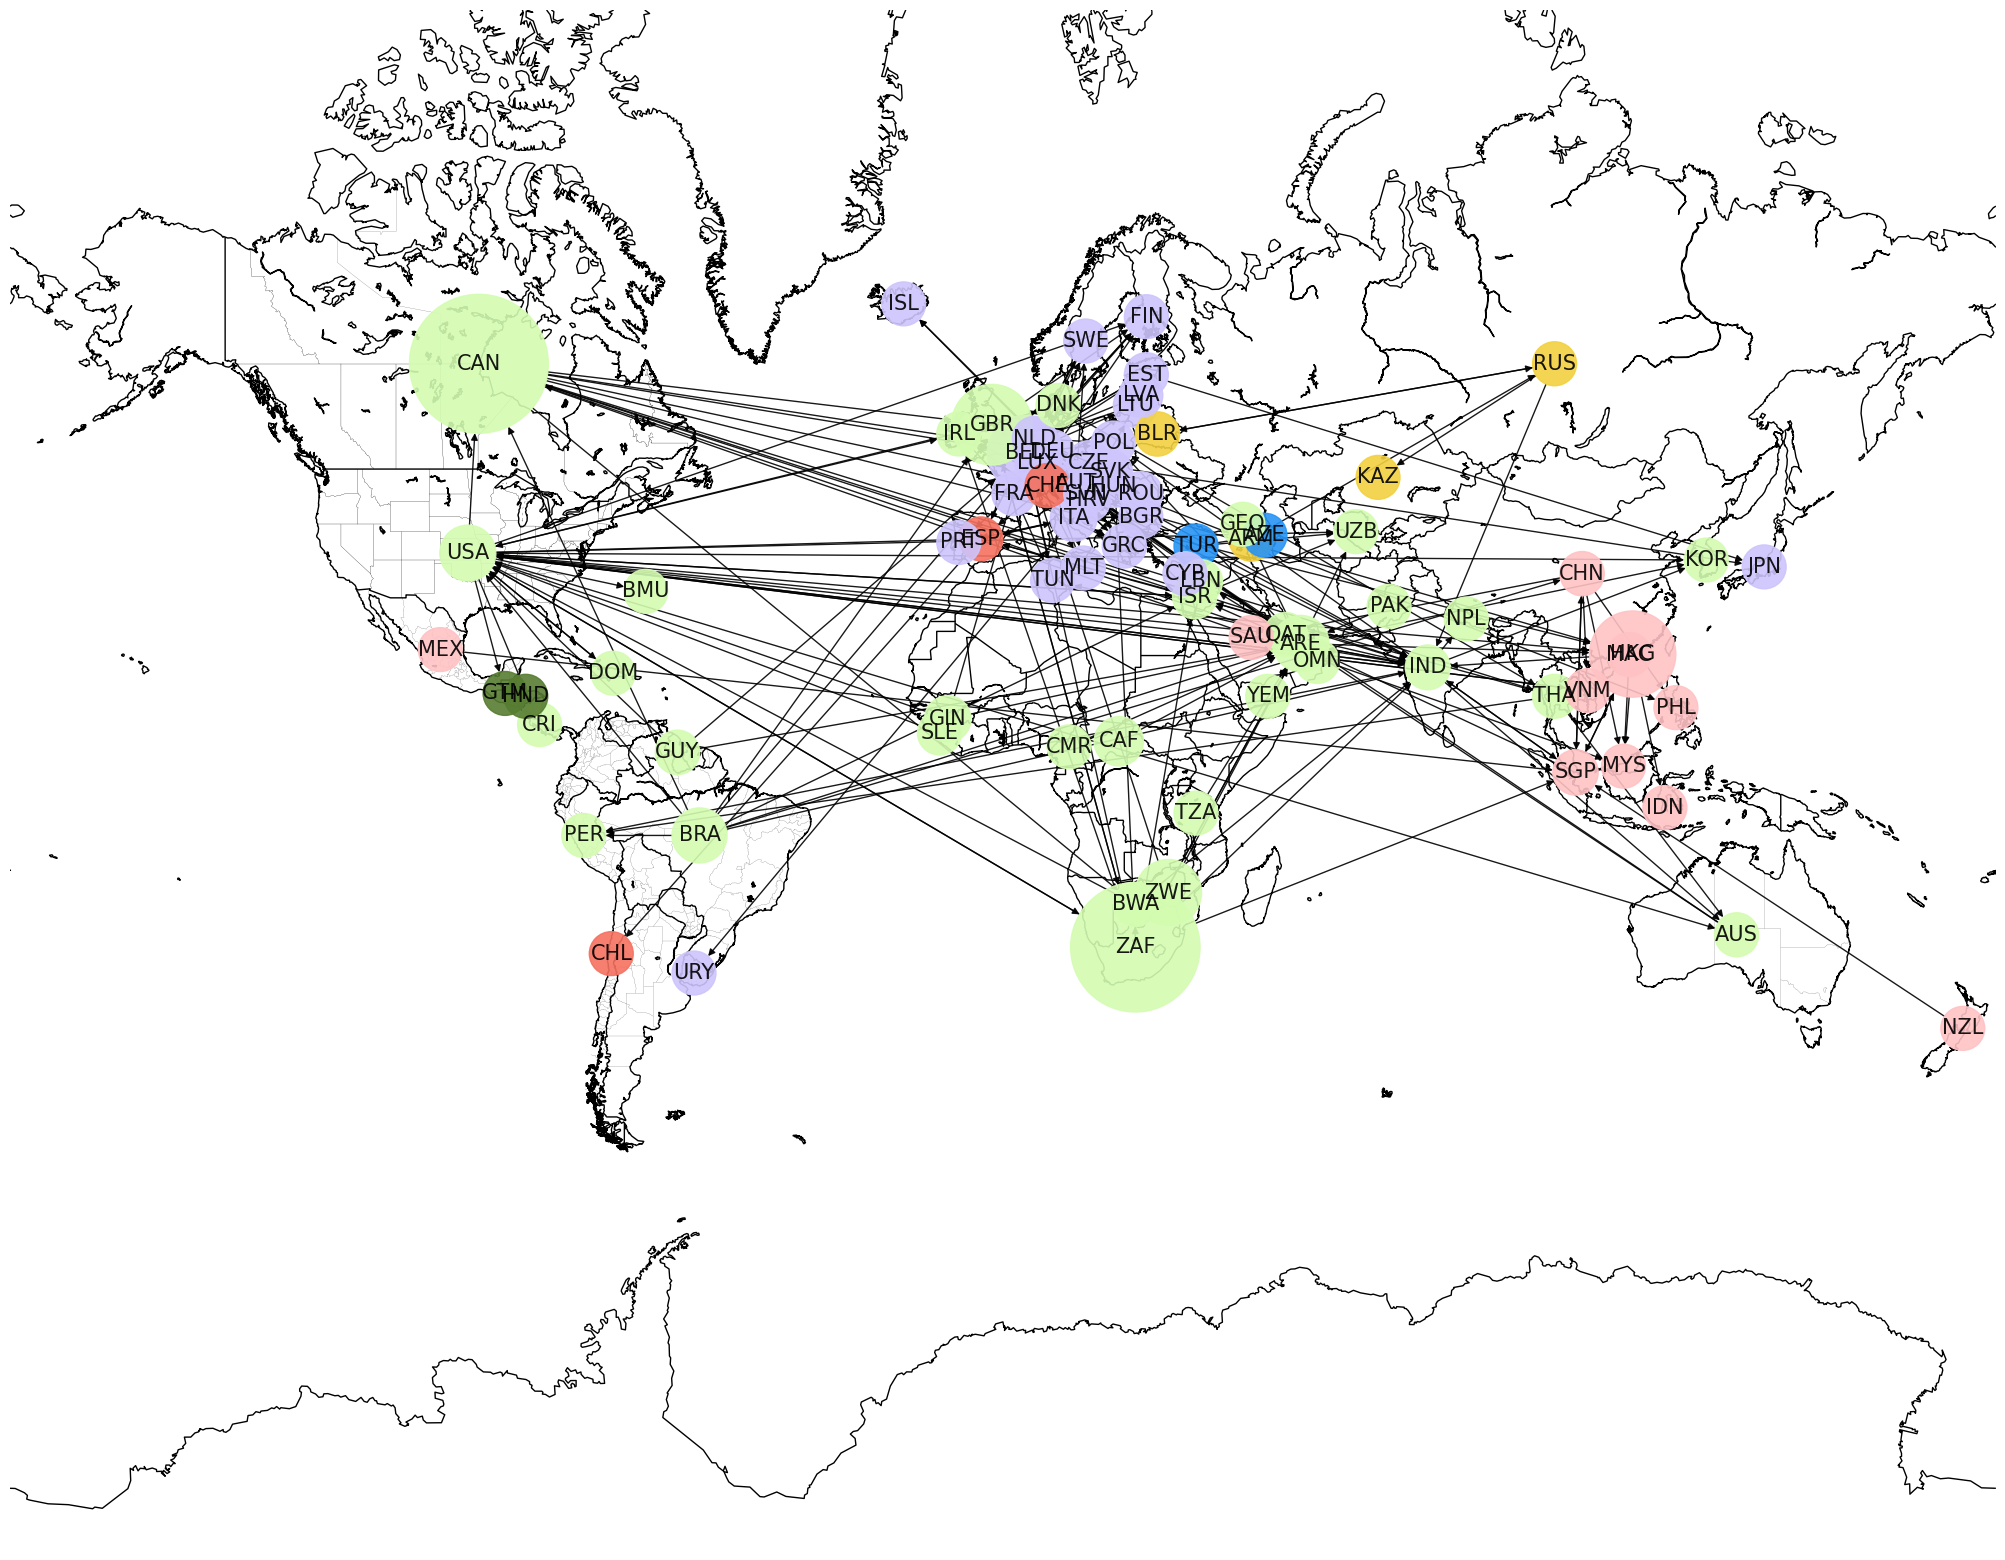

In [12]:
community = nx.community.greedy_modularity_communities(G_diamonds)

plt.figure(figsize=(30,20))
visualize_communities(G_diamonds, community)
plt.show()

## Further Scope